In [0]:
import pandas as pd
from functools import partial 
import numpy as np
from scipy.optimize import minimize
from scipy.stats import random_correlation
import pickle
from time import time
import matplotlib.pyplot as plt
import cProfile

### 1. Data Generation Process
Generate correlated returns and store them as pickles. returns a $2500 \times n$ matrix where $n$ is the number of stocks in portfolio.   

In [0]:
def get_simulated_rets(n):
    mu = np.random.normal(size = n) # daily mean ret, in pct
    sd = np.random.normal(0.5,size = n) # daily ret sd, in pct
    eigs = np.random.random(n)
    
    # Assume 4 large eigenvalues and rest of them are equal
    eigs = 0.5
    max2_eig = int (0.2 * n)
    max3_eig = int (0.15 * n)
    max4_eig = int (0.05 * n)
    max1_eig = n - max2_eig - max3_eig - max4_eig - eigs * (n-4)
    
    cor_matrix = random_correlation.rvs([max1_eig,max2_eig,max3_eig,max4_eig] + [eigs]*(n-4))  
    cov_matrix = np.diag(sd) @ cor_matrix @ np.diag(sd)
    rets = np.random.multivariate_normal(mu,cov_matrix,size = [2500])
    return rets

# data generation process
# for n in range(100,1001,100):    
#     rets = get_simulated_rets(n)
#     mu = rets.mean(axis = 0)
#     cov_matrix = np.cov(rets.T)  
#     file = open('mu_cov_matrix_%s.dat' %n, 'wb')
#     pickle.dump(mu, file)
#     pickle.dump(cov_matrix, file)
#     file.close()

# rets = get_simulated_rets(100)
# mu = rets.mean(axis = 0)
# cov_matrix = np.cov(rets.T) 


### 2. Quadratic Optimization using scipy
Below we do quadratic optimization the standard way: using $scipy.optimize$

In [0]:
# some helper functions
def get_var(weights, cov_matrix):
    return np.dot(np.dot(weights.T, cov_matrix), weights)

def get_ret(weights,mu):
    return np.sum(mu * weights)

def true_weight(cov_matrix,mu,target_r):
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    eta =inv_cov_matrix @ mu / (mu.T @ inv_cov_matrix @ mu)
    true_weights = target_r * eta
    return true_weights

def evaluate(opts,true_weights,cov_matrix):
    l2norm = np.linalg.norm(true_weights-opts['x'])
    loss = get_var(opts['x'], cov_matrix) * 1000
    trueloss = get_var(true_weights, cov_matrix) * 1000
    return (l2norm,round(loss,6),round(trueloss,6),opts['success'])

def load_data(n):
    # load pickle
    with open('mu_cov_matrix_%s.dat' %n, "rb" ) as f:
        mu = pickle.load(f)
        cov_matrix = pickle.load(f)
    return (mu,cov_matrix)

##### 2.1 Optimization I: Equality Constraint Only

We solve the following problem:
\begin{equation}
\min_{\alpha} \alpha^T V \alpha \\
\text{s.t.}   \mu^T\alpha = r
\end{equation}
which is quivalent to finding the minimum risk portfolio with given return constraint. For this simple problem with no inequality constraint, there is an analytical solution:
\begin{equation}
\alpha^* = \frac{V^{-1}\mu}{\mu^T V^{-1}\mu} r
\end{equation}
which is implemented in $\textbf{true_weights}$ function.

In [0]:
def quad_opt_eq(mu,cov_matrix,target_r = 3.0,method = 'SLSQP',tol = 1e-6):
    n = len(mu)
    # the constraints
    cons = ({'type': 'eq', 'fun': lambda x:  get_ret(x,mu) - target_r})
    x0 = np.zeros(n)    
    #optimization
    opts = minimize(get_var,x0,args = (cov_matrix),method = method,constraints=cons,tol = tol)  
    return opts

In [5]:
target_r = 1.4
mu,cov_matrix = load_data(100)
opts = quad_opt_eq(mu,cov_matrix,target_r)
weights = opts['x']

true_weights = true_weight(cov_matrix,mu,target_r)
#display results
rs = pd.DataFrame({'mu':mu.round(4),'weights':weights.round(4),'true_weights':true_weights.round(4)})
rs_df = rs[rs.weights >0].sort_values('weights',ascending = False)[:5]

assert(abs(get_ret(weights,mu) - target_r) < 1e-6)
rs_df

,mu,weights,true_weights
11,1.2025,0.4541,0.4150
81,1.7485,0.0179,0.0196
56,2.3980,0.0178,0.0162
66,1.0411,0.0167,0.0147
75,2.4700,0.0139,0.0123


##### 2.2 Optimization II: Adding Inequality Constraint

We solve the following problem:

\begin{align}
\min_{\alpha} & \alpha^T V \alpha \\
\text{s.t.}   & \mu^T\alpha = r \\
 & 1^T\alpha  = 1 \\
 & \alpha \geq = 0
\end{align}

which is quivalent to finding the minimum risk portfolio with given return constraint. In addition, we require all money should be utilized: $1^T\alpha  = 1$, and no short-selling: $\alpha \geq = 0$ (i.e. you cannot sell the stocks that you do not own). For this problem there is NO analytical solution.


In [0]:
def quad_opt_ineq(mu,cov_matrix,target_r = 3.0,method = 'SLSQP',tol = 1e-6):
    n = len(mu)
    # the constraints
    cons = ({'type': 'eq','fun': lambda x:  get_ret(x,mu) - target_r},
            {'type': 'eq', 'fun': lambda x:  sum(x)-1})
    bounds = [(0.00000001,1.0000001) for _ in range(n)]
    x0 = np.ones(n)/n   
    #optimization
    opts = minimize(get_var,x0,args = (cov_matrix),method = method,constraints=cons,bounds= bounds,tol = tol) 
    return opts

In [7]:
target_r = 1.4
mu,cov_matrix = load_data(100)

#optim result
opts = quad_opt_ineq(mu,cov_matrix,target_r)
weights = opts['x']

#display results
rs = pd.DataFrame({'mu':mu.round(4),'weights':weights.round(4)})
rs_df = rs[rs.weights >0].sort_values('weights',ascending = False)[:5]

assert(abs(get_ret(weights,mu) - target_r) < 1e-6)
assert(abs(sum(weights) - 1) < 1e-6)

rs_df

,mu,weights
11,1.2025,0.7811
56,2.3980,0.0768
81,1.7485,0.0572
75,2.4700,0.0564
66,1.0411,0.0056


### 3. Primal_dual IPM Method

##### 3.1 Part I: Primal_Dual Formulation and KKT Conditions
Assume we would like to solve the following problem (Primal)

\begin{align}
\min_{x} \ & x^T Q x + c^T x \\
\text{s.t.} \  & Ax = b \\
 & x \geq  0
\end{align}


if Q is positive semidefinite, the problem is convex. Denote optimal value is $p^*$, which is the value we want to find (a.k.a the primal solution).

Below we introduce the dual fuction.

The Lagrangian function is:

\begin{align}
\mathcal{L}(x, y, s) = x^T Q x + c^T x + y^T(Ax - b) - s^Tx 
\end{align}

where $y$ and $s$ are lagrangian multiplers for the constraints.

The lagrange dual function is defined as: $$g(y, s) = \inf_x \mathcal{L}(x, y, s) $$

To obtain $g(y, s)$, we minimize $\mathcal{L}$ over $x$,  which is equivalent to setting gradient equal to zero:

\begin{align}
\frac{\partial\mathcal{L}}{\partial x}(x, y, s) & = 2 Q x + c - s + A^Ty = 0 \\
x & = - Q^{-1}(c - s + A^Ty)/2
\end{align}

Plugging $x$ into $\mathcal{L}$ give the expression of $g(y, s)$.

Lagrange dual problem
\begin{align}
\max_{y,s} \ & g(y,s) \\
\text{s.t.} \  & s \geq  0
\end{align}

the solution to this dual problem is called $d^*$.

Strong duality holds ($d^* = p^*$) if the problem is convex, and the inequality constraints is strictly feasible (Slater's condition).

complementary slackness:
Denote $x^*$ is primal optimal, $(y^*, s^*)$ is dual optimal. If strong duality holds, then $s_ix_i = 0$,  $\forall i$


Combining the above, we have the famous Karush-Kuhn-Tucker (KKT) conditions

1. primal constraints:  $Ax = b, x \geq = 0$
2. dual constraints: $s ≥ 0$
3. complementary slackness: $s_ix_i = 0$,  $\forall i$
4. gradient of Lagrangian with respect to x vanishes: $2Qx + c − s + A^Ty = 0$

It can be proved that if $(x^*, y^*, s^*)$ satisfy KKT for a convex problem, then they are optimal.

In matrix form:
\begin{equation}
F(x^*, y^*, s^*)
= \begin{bmatrix}
2Qx^* + c − s^* + A^Ty^* \\
Ax^* - b \\
X^*S^*\mathbb{1} \\
\end{bmatrix} = 
\begin{bmatrix}
0 \\
0 \\
0 \\
\end{bmatrix}, s ≥ 0 ,x ≥ 0
\end{equation}

The system of equations $F(x, y, s) = 0$ is a square system. So we can apply Newton’s method if we discard the nonnegativity
constraints. Now we have change the quadratic problem into linear problem.


##### 3.2 Part II: Solving KKT matrix by Interior Point Method (IPM)


###### 3.2.1 Central Path Parameterization

The existence of nonnegativity constraints creates a difficulty.

Define the feasible set

$$F := \{(x, y, s) : 2Qx + c − s + A′y = 0,Ax = b, x ≥ 0, s ≥ 0\}$$


Relative interior of the feasible set:
$$F^0 := \{(x, y, s) : 2Qx + c − s + A′y = 0,Ax = b, x > 0, s > 0\}$$

Interior-point methods:
1. It generates a sequence of points $(x_k,y_k,s_k) \in F^0$ (This is why is called interior-point method).
2. The sequence gets progressively closer to satisfying the third block of equations ($s_ix_i = 0$,  $\forall i$)

Parameterized a trajectory by a scalar $\tau > 0$:
\begin{equation}
F(x_\tau, y_\tau, s_\tau)
= \begin{bmatrix}
2Qx_\tau + c − s_\tau + A^Ty_\tau \\
Ax_\tau - b \\
X_\tau S_\tau \mathbb{1} \\
\end{bmatrix} = 
\begin{bmatrix}
0 \\
0 \\
\tau \mathbb{1} \\
\end{bmatrix}, s_\tau > 0 ,x_\tau > 0
\end{equation}

as $\tau → 0, (x_\tau, y_\tau, s_\tau)$ converges to an optimal solution.


###### 3.2.2 Newton Method
Formula for the Newton update:
$$x_{k+1} = x_k − \Delta F(x_k)^{−1}F(x_k)$$

Plug in the above equation:

\begin{equation}
\begin{bmatrix}
x_{k+1}\\
y_{k+1}\\
s_{k+1}\\
\end{bmatrix} = 
\begin{bmatrix}
x_k\\
y_k\\
s_k\\
\end{bmatrix} -
\begin{bmatrix}
2Q & A^T  & -I \\
A & 0  & 0 \\
S_k & 0  & X_k \\
\end{bmatrix}^{-1}
\begin{bmatrix}
0 \\
0 \\
\tau \mathbb{1}\\
\end{bmatrix}
\end{equation}

For $\tau > 0$, solving for the point $(x_\tau, y_\tau, s_\tau)$ is difficult. However, it is relatively easy to find an approximation. One way is to define:

$$\tau_k = (x_k)′(s_k)/n$$

Then $(x_k , y_k , s_k )$ is close to the central point corresponding to $\tau_k$. 

Further let $\sigma_k \in (0, 1)$ and let $ \tau_{k+1} = \sigma\tau_k$ so that we have $\tau_{k+1}  < \tau_k$ , Now the iterations approximate the optimal solution as $k$ increases.




###### 3.2.3 IPM Finally
The Primal_dual IPM method is the following:

1.choose $(x_0,y_0,s_0) \in F^0$ 

2.Repeat the following until convergence:

Choose $\sigma \in (0, 1)$. Let $\tau = \frac{s^Tx}{n}$.Solve:

\begin{equation}
\begin{bmatrix}
\Delta x\\
\Delta y\\
\Delta s\\
\end{bmatrix} 
= \begin{bmatrix}
2Q & A^T  & -I \\
A & 0  & 0 \\
S & 0  & X \\
\end{bmatrix}^{-1}
\begin{bmatrix}
0 \\
0 \\
XS \mathbb{1} - \sigma\tau \mathbb{1}\\
\end{bmatrix}
\end{equation}

Choose $\eta_k$ such that after updating, x and s remains > 0
and updates:

\begin{equation}
\begin{bmatrix}
x\\
y\\
s\\
\end{bmatrix} 
-= 
\eta_k
\begin{bmatrix}
\Delta x\\
\Delta y\\
\Delta s\\
\end{bmatrix}
\end{equation}


In [0]:
# verify if inintial point is in the interior
def verify_initial_point(Q,c,A,b,x,s,y,threshold = 1e-9):
    c1 = max(abs(2 * Q @ x + c - s + A.T @ y)) < threshold
    c2 = max(abs(A @ x - b)) < threshold
    c3 = (x > 0).all()
    c4 = (s > 0).all()
    return c1 & c2 & c3 & c4
    
def primal_dual_IPM_solver(Q,c,A,b,x,s,y,target_r,tol = 1e-8,max_iter = 5000):
    
    if not verify_initial_point(Q,c,A,b,x,s,y):
        raise ValueError('The parameter supplied is not an interior point.')
    
    n = Q.shape[0]
    m = A.shape[0]
    I = np.identity(n)
    target = np.concatenate((x,y,s))
    S = np.diag(s)
    X = np.diag(x)
    DF = np.block([
            [2*Q,A.T,-I],
            [A,np.zeros((m,m)),np.zeros((m,n))],
            [S,np.zeros((n,m)),X] 
        ])
    
    mod_cord_x = [x for x in range(n+m,2*n+m)]
    mod_cord_DFy1 = [y1 for y1 in range(n)]
    mod_cord_DFy2 = [y2 for y2 in range(n+m,2*n+m)]
    
    k = 1
    #loop until convergence
    while True:
        k += 1
        sigma = 1/np.sqrt(k)
        x,y,s = target[:n],target[n:n+2],target[n+2:]
        tau = np.average(x * s)

        F = np.concatenate((np.zeros(n+m),x * s - tau * sigma))
        
        DF[mod_cord_x,mod_cord_DFy1] =  s
        DF[mod_cord_x,mod_cord_DFy2] =  x
        
        # get delta_target
        update_ = np.linalg.inv(DF) @ F
        
        # selects eta_k: 
        ut_ratio = update_/target
        xs_ratios = np.concatenate([ut_ratio[:n],ut_ratio[n+2:]],0)       
        eta = 1/np.max(xs_ratios) * 0.9999
        
        #updates
        target -= eta * update_
        
        # terminate condition
        if (np.linalg.norm(F) < tol) or (k == max_iter):
            break
            
    return {'x':target[:n],
           'y':target[n:n+2],
           's':target[n+2:]}

##### 3.2.4 Generate Interior Point
The most difficult part of IPM is to choose $(x_0,y_0,s_0) \in F^0$ as starting point. Luckily for this question it is not difficult to find one. Here we present 2 methods:

1. running scipy minimizer with very high tolarance (general)
2. compute directly by assigning weights among the highest return assert and the lowest one (faster)

In [0]:
def get_initial_point_scipy(Q,c,A,b,n,target_r):
    '''
        generate x,s and y vectors from Q,c,A,b, such that they are in feasible region
        1. x in obtained by running scipy minimizer with very high tolarance (this is fast)
        2. this x satisfies 𝐴𝑥=𝑏,𝑥>0 automatically
        3. from the first condition, 𝑄𝑥+𝑐−𝑠+𝐴′𝑦=0 => 𝑠 = 𝑄𝑥+𝐴′𝑦
           so we need to find y such that 𝑠 = 𝑄𝑥+𝐴′𝑦 = 𝑄𝑥+𝑦[0]𝜇+𝑦[1]𝟙 > 0
           arbitrarily set y[0] = 1, so we only need 𝑦[1] > min(|𝑄𝑥+𝜇|) and all condition satified.
    '''
    itol = 1
    while True:

        itol = itol/10
        opts = quad_opt_ineq(A[0,:],Q,target_r = target_r,method = 'SLSQP',tol = itol)
        x = opts['x']
        y = (1, - min(Q @ x + A.T @ (1,0)) * 1.01)
        s = 2*Q @ x + A.T @ y

        if verify_initial_point(Q,c,A,b,x,s,y):
            break
    return (x,y,s)

def get_initial_point_direct(Q,c,A,b,n,target_r):
    '''
        generate x,s and y vectors from Q,c,A,b, such that they are in feasible region
        assign x% to max return stock, (99-x)% to min stock, and 1%/(n-2) evenly to other stocks
        x * r_max + (0.99-x) * r_min + 0.01 * r_others = target_r
    '''
    mu = A[0,:]
    max_index = np.argmax(mu)
    r_max = mu[max_index]
    min_index = np.argmin(mu)
    r_min = mu[min_index]
    r_others = np.average(np.delete(mu, [max_index,min_index]))

    # assign x% to max return stock, (99-x)% to min stock, and 1%/(n-2) evenly to other stocks
    # x * r_max + (0.99-x) * r_min + 0.01 * r_others = target_r
    t2 = time()
    x_max = (target_r - 0.01 * r_others - 0.99 * r_min)/(r_max - r_min)
    x_min = 0.99 - x_max

    x = np.ones(n)/(n-2)*0.01
    x[max_index] = x_max
    x[min_index] = x_min

    y = np.asarray((1, - min(2*Q @ x + A.T @ (1,0)) * 1.01))
    s = 2*Q @ x + A.T @ y
    assert verify_initial_point(Q,c,A,b,x,s,y)
    return (x,y,s)

##### 3.2.5 An example

In [10]:
n = 100
target_r = 1.4
mu,cov_matrix = load_data(n)

#parameters for IPM
Q = cov_matrix
c = np.zeros(n)
A = np.vstack((mu,np.ones(n)))
b = np.array([target_r,1])
x,y,s = get_initial_point_direct(Q,c,A,b,n,target_r)

#optim result
opts = primal_dual_IPM_solver(Q,c,A,b,x,s,y,target_r)
weights = opts['x']

#display results
rs = pd.DataFrame({'mu':mu.round(4),'weights':weights.round(4)})
rs_df = rs[rs.weights >0].sort_values('weights',ascending = False)[:5]

assert(abs(get_ret(weights,mu) - target_r) < 1e-6)
assert(abs(sum(weights) - 1) < 1e-6)

rs_df

,mu,weights
11,1.2025,0.7791
56,2.3980,0.0732
81,1.7485,0.0615
75,2.4700,0.0578
80,1.9634,0.0050


In [12]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 61kB 28.5MB/s 
     |████████████████████████████████| 460kB 60.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/a5/17/ac/99922221c732eeece43529d3e0f9d441f7301c75990b2cdbff
  Stored in directory: /root/.cache/pip/wheels/83/df/0b/75ac4572aaa93e3eba6a58472635d0fda907f5f4cf884a3a0c
  Stored in directory: /root/.cache/pip/wheels/46/23/48/366f0d8b14d436e58ad0aef531b14af8d8beabeb2986704bd5
Successfully built pycuda pytools mako


### 4. IPM with CUDA

In [13]:
## TODO: Reimplement primal_dual_IPM_solver using CUDA
import torch
import pycuda.driver as cuda
cuda.init()
print(torch.cuda.get_device_name(0))
test = torch.cuda.FloatTensor(np.identity(3))
torch.inverse(test)

Tesla T4


tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')

In [0]:
def primal_dual_IPM_solver_CUDA(Q,c,A,b,x,s,y,target_r,tol = 1e-8,max_iter = 5000):
    
    if not verify_initial_point(Q,c,A,b,x,s,y):
        raise ValueError('The parameter supplied is not an interior point.')
    
    n = Q.shape[0]
    m = A.shape[0]
    I = np.identity(n)
    target = np.concatenate((x,y,s))
    S = np.diag(s)
    X = np.diag(x)
    DF = np.block([
            [Q,A.T,-I],
            [A,np.zeros((m,m)),np.zeros((m,n))],
            [S,np.zeros((n,m)),X] 
        ])

    x = torch.cuda.FloatTensor(x)
    y = torch.cuda.FloatTensor(y)
    s = torch.cuda.FloatTensor(s)
    target = torch.cuda.FloatTensor(target)
    DF = torch.cuda.FloatTensor(DF)
    F = torch.cuda.FloatTensor([0] * (2*n+m))

    mod_cord_x = [x for x in range(n+m,2*n+m)]
    mod_cord_DFy1 = [y1 for y1 in range(n+m,2*n+m)]
    mod_cord_DFy2 = [y2 for y2 in range(n)]

    k = 1
    #loop until convergence
    while True:
        k += 1
        sigma = 1/np.sqrt(k)
        tau = torch.mean(x * s)
        
        F = torch.cat((torch.cuda.FloatTensor(n+m).fill_(0),x * s - tau * sigma))
        
        DF[mod_cord_x,mod_cord_DFy1] =  x
        DF[mod_cord_x,mod_cord_DFy2] =  s
        
        # get delta_target
        update_ = torch.inverse(DF) @ F

        # selects eta_k: 
        ut_ratio = update_/target
        xs_ratios = torch.cat((ut_ratio[:n],ut_ratio[n+2:]),0)        
        eta = 1/torch.max(xs_ratios) * 0.9999
        
        #updates
        target -= eta * update_
        x,y,s = target[:n],target[n:n+2],target[n+2:]

        # terminate condition
        if (torch.norm(F) < tol) or (k == max_iter):
            break

    return {'x':x.cpu().numpy(),
           'y':y.cpu().numpy(),
           's':x.cpu().numpy()}

### 5. Result

In [0]:
def time_wrapper(n):
    
    #parameters
    target_r = 1.4
    mu,cov_matrix = load_data(n)
    Q = cov_matrix
    c = np.zeros(n)
    A = np.vstack((mu,np.ones(n)))
    b = np.array([target_r,1])
    x,y,s = get_initial_point_direct(Q,c,A,b,n,target_r)
    
    t1 = time()
    opt_1 = quad_opt_ineq(mu,cov_matrix,target_r)
    weights_1 = opt_1['x']
    var1 = get_var(weights_1, cov_matrix)
    
    t2 = time()
    opt_2 = primal_dual_IPM_solver_CUDA(Q,c,A,b,x,s,y,target_r)
    weights_2 = opt_2['x']
    var2 = get_var(weights_2, cov_matrix)
    
    t3 = time()
    opt_3 = imp_result = primal_dual_IPM_solver(Q,c,A,b,x,s,y,target_r)
    weights_3 = opt_3['x']
    var3 = get_var(weights_3, cov_matrix)
    
    t4 = time()
    return (var1,var2,var3,(t2-t1),(t3-t2),(t4-t3))  

In [16]:
# run all
from tqdm import tqdm_notebook as tqdm

ns = np.array(range(100,1001,100))
var_ipm = []
var_scipy = []
var_CUDA = []
time_ipm = []
time_scipy = []
time_CUDA = []
for i in tqdm(range(len(ns))):
    n = ns[i]
    var1,var2,var3,t1,t2,t3 = time_wrapper(n)
    var_scipy += [var1]
    var_CUDA += [var2]
    var_ipm += [var3]
    time_scipy += [t1]
    time_CUDA += [t2]
    time_ipm += [t3]


In [17]:
df = pd.DataFrame({
    'N':ns,
    'Loss_IPM':np.log(np.array(var_ipm)*1e8),
    'Loss_IPM_CUDA':np.log(np.array(var_CUDA)*1e8),
    'Loss_scipy': np.log(np.array(var_scipy)*1e8),
    'Time_IPM': time_ipm,
    'Time_IPM_CUDA': time_CUDA,
    'Time_scipy': time_scipy
})

df

,N,Loss_IPM,Loss_IPM_CUDA,Loss_scipy,Time_IPM,Time_IPM_CUDA,Time_scipy
0,100,10.902668,14.698926,10.904437,0.029450,0.280284,0.289609
1,200,11.388414,17.623390,11.396969,0.241516,0.374065,1.956421
2,300,10.643061,17.479053,10.667394,0.839234,0.520677,6.924826
3,400,7.922257,15.094167,8.935306,1.235256,0.544350,15.464932
4,500,2.591624,18.497749,7.820335,2.761444,0.712939,48.282545
5,600,8.275516,17.336717,8.614818,4.234648,0.688087,63.667489
6,700,8.679422,17.264821,9.069857,7.720222,0.772858,77.087355
7,800,6.331633,17.158611,8.147177,12.566241,1.077450,92.099339
8,900,5.727678,17.830427,8.060618,13.809741,1.093675,155.723782
9,1000,4.780269,15.319745,8.388413,20.279135,1.240140,224.209883


In [0]:
def plot(df):
    
    fig, ax1 = plt.subplots(figsize = (9,6),dpi = 200)

    ax2 = ax1.twinx()
    
    # bar chart
    s1 = ax1.bar(ns - 7.5, df['Loss_IPM'],color = 'purple',width = 15)
    s2 = ax1.bar(ns + 7.5, df['Loss_scipy'],color = 'orange',width = 15)
    
    # line chart
    s3 = ax2.plot(ns, df['Time_IPM'],
                  color = 'purple',
                  marker='o',markersize=6, 
                  markerfacecolor='purple',
                  markeredgewidth=1.5, 
                  markeredgecolor='w', 
                  linewidth=2.0,
                  alpha = 0.4)
    
    s4 = ax2.plot(ns, df['Time_scipy'],
                  color = 'orange',
                  marker='o',markersize=6, 
                  markerfacecolor='orange',
                  markeredgewidth=1.5, 
                  markeredgecolor='w', 
                  linewidth=2.0)
    
    s5 = ax2.plot(ns, df['Time_IPM_CUDA'],
                  color = 'purple',
                  marker='o',markersize=6, 
                  markerfacecolor='purple',
                 markeredgewidth=1.5, 
                  markeredgecolor='w', 
                  linewidth=2.0)

    plt.rcParams['hatch.color'] = 'w'
    
    for x in range(len(ns)):
        
        # text
        ipm_time = df.loc[x,'Time_IPM']
        ipmc_time = df.loc[x,'Time_IPM_CUDA']
        spy_time = df.loc[x,'Time_scipy']
    
        ax2.text(ns[x]+2, ipmc_time-10, str(round(ipmc_time,2)), 
                 color='w',fontsize = 7, fontweight='bold', 
                 bbox=dict(facecolor='purple', edgecolor='white',boxstyle='Round,pad=0.4'))

        if (len(str(spy_time)) >= 5):
            shift = 60
        else:
            shift = 45

        ax2.text(ns[x]-shift, spy_time+5, str(round(spy_time,2)),
                 color='w',fontsize = 7, fontweight='bold', 
                 bbox=dict(facecolor='orange', edgecolor='white',boxstyle='Round,pad=0.4'))

        # reduction in error
        if df.loc[x,'Loss_scipy'] > df.loc[x,'Loss_IPM']:
            
            sploss = df.loc[x,'Loss_scipy']
            ipmloss = df.loc[x,'Loss_IPM']
            pct = str(round((ipmloss/sploss -1 ) * 100,2)) + '%'
            
            ax1.bar(ns[x] - 7.5,sploss - ipmloss, bottom = ipmloss,
                    width = 15,color = 'purple', 
                    hatch = "\\"*10 ,alpha = 0.3)
            
            ax1.text(ns[x] - 20, sploss + 0.5, pct,
                     color='w',fontsize = 7, fontweight='bold', 
                     bbox=dict(facecolor='purple', edgecolor='white',
                               boxstyle='Round,pad=0.4', hatch = "\\"*10 ,alpha = 0.3))

    
    ax1.set_xlabel('Portfolio Size ($n$)')
    ax1.set_ylabel('Bar: Log Loss(1e8)')
    ax2.set_ylabel('Line: Run Time ($s$)')
    ax1.set_ylim((0,15))
    plt.title('Performance vs Portfolio Size')
    
    plt.legend((s1[0], s2[0],s3[0],s5[0],s4[0]), 
               ('Loss_IPM', 'Loss_scipy','Runtime_IPM','Runtime_IPM(CUDA)','Runtime_scipy'), 
               fontsize = 8)

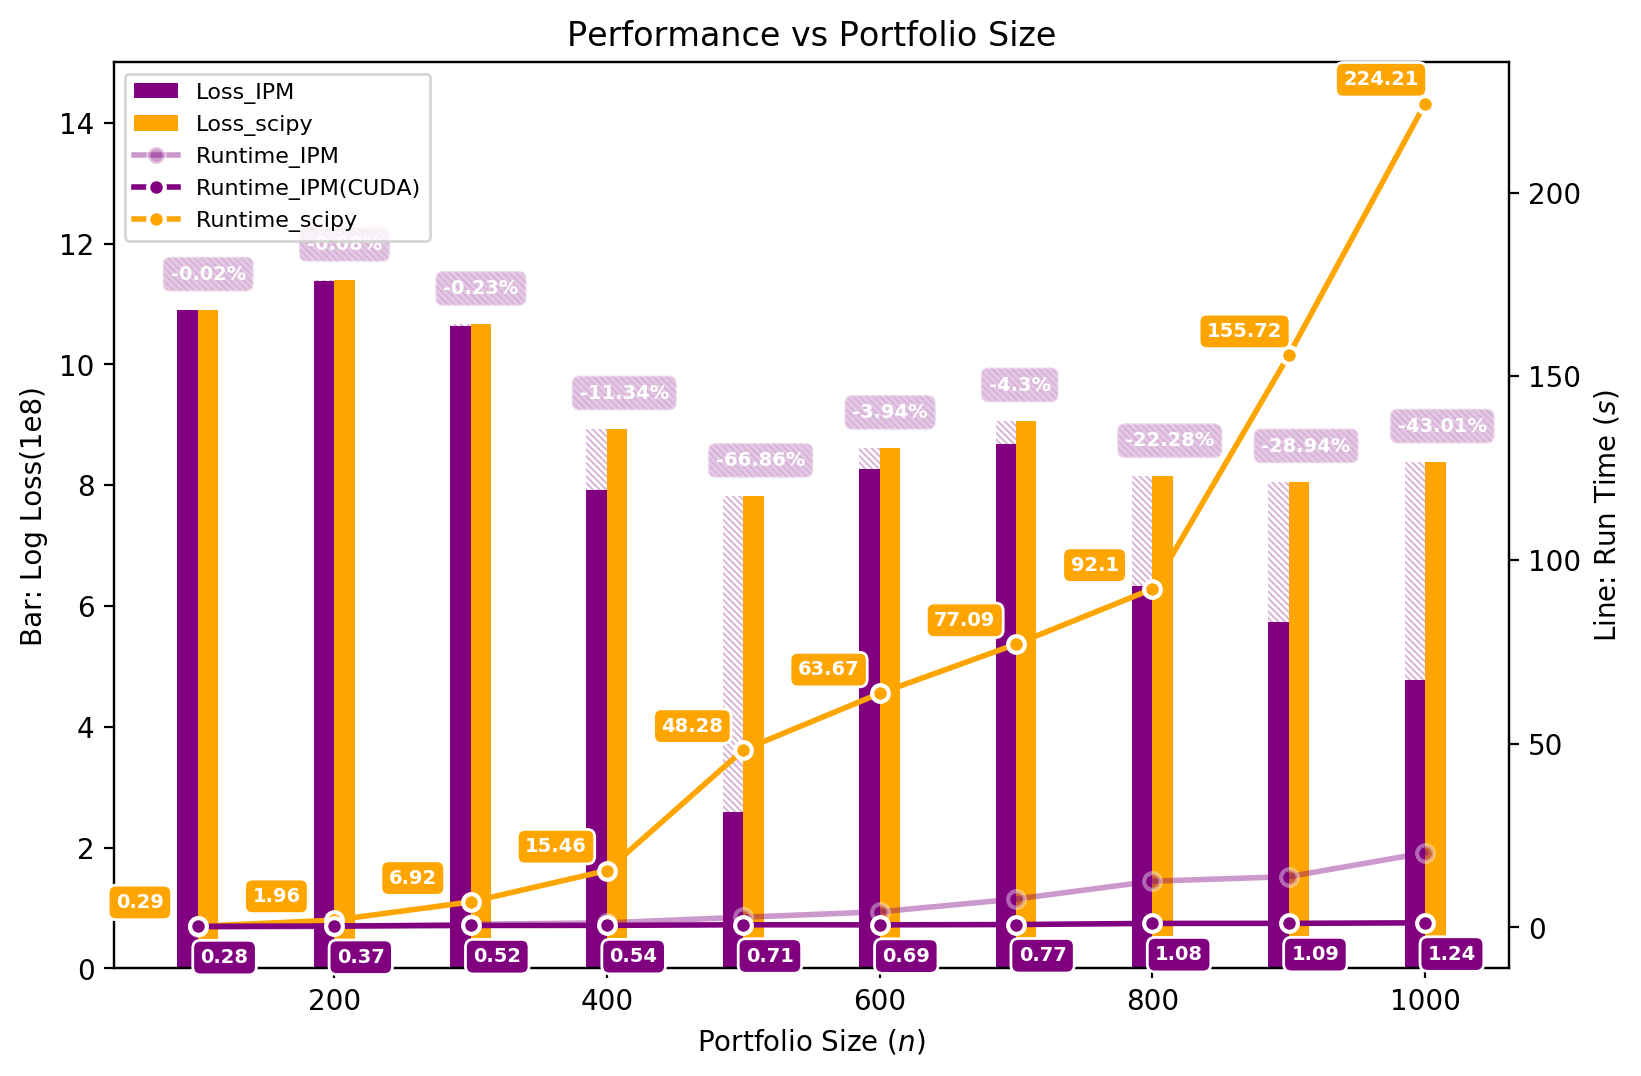

In [19]:
plot(df)